In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import shap
import warnings
warnings.filterwarnings('ignore')

# Set Chinese font
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Read data
train_df = pd.read_excel('training_set_balanced.xlsx')
test_df = pd.read_excel('test_set.xlsx')
validation_df = pd.read_excel('validation_set.xlsx') 

# Prepare features and labels
def prepare_data(df):
    X = df.drop('labels', axis=1)
    y = df['labels']
    return X, y

X_train, y_train = prepare_data(train_df)
X_validation, y_validation = prepare_data(validation_df)

# Feature column names list
feature_columns = X_train.columns.tolist()

# LGBM model optimal features and hyperparameters
lgbm_features = [0, 1, 2, 3, 4, 5, 9, 13, 18, 19, 22, 24, 25, 27, 28, 29, 30]
lgbm_params = {'learning_rate': 0.1, 'n_estimators': 300}

# Select optimal features
selected_features = [feature_columns[i] for i in lgbm_features]

X_train_selected = X_train[selected_features]
X_validation_selected = X_validation[selected_features]

# Train LGBM model
lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model.fit(X_train_selected, y_train)

val_proba = lgbm_model.predict_proba(X_validation_selected)[:, 1]
fpr, tpr, thr = roc_curve(y_validation, val_proba)

youden = tpr - fpr
best_idx = np.argmax(youden)
best_thr = float(thr[best_idx])

# Model evaluation
def evaluate_model(model, X, y, threshold, dataset_name):
    """Evaluate model performance"""
    
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    accuracy = accuracy_score(y, y_pred)
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, y_proba

fpr_train, tpr_train, auc_train, train_proba, train_pred = evaluate_model(
    lgbm_model, X_train_selected, y_train, best_thr, "Training set"
)

fpr_validation, tpr_validation, auc_validation, val_proba, val_pred = evaluate_model(
    lgbm_model, X_validation_selected, y_validation, best_thr, "Validation set"
)

X_test_selected = X_test[selected_features]
fpr_test, tpr_test, auc_test, probs_test, preds_test = evaluate_model(
    lgbm_model, X_test_selected, y_test, best_thr, "Test set"
)

# SHAP feature importance analysis
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_train_selected)

# For binary classification, take SHAP values for positive class
if isinstance(shap_values, list):
    shap_values = shap_values[1]

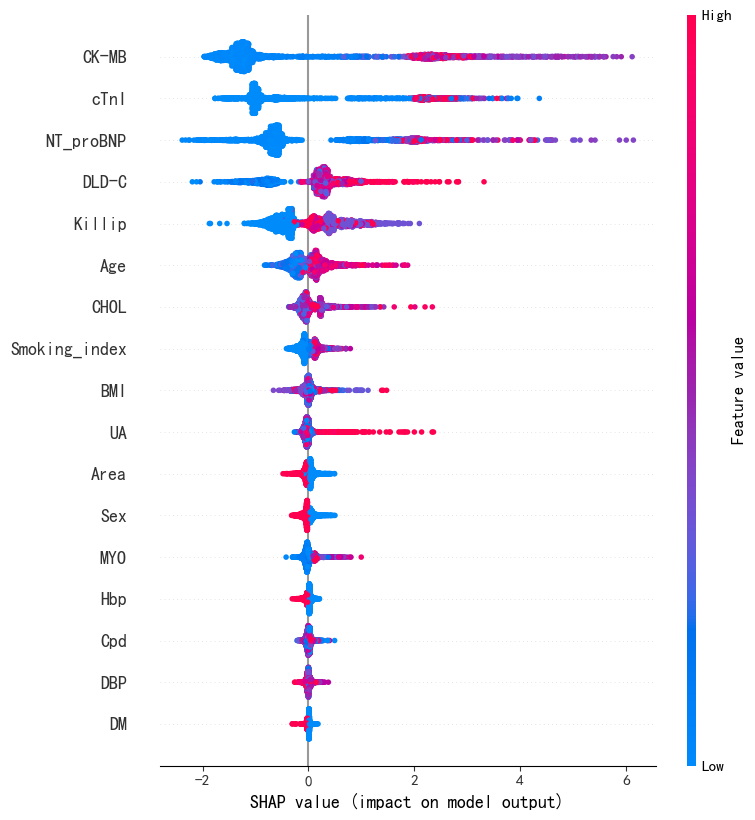

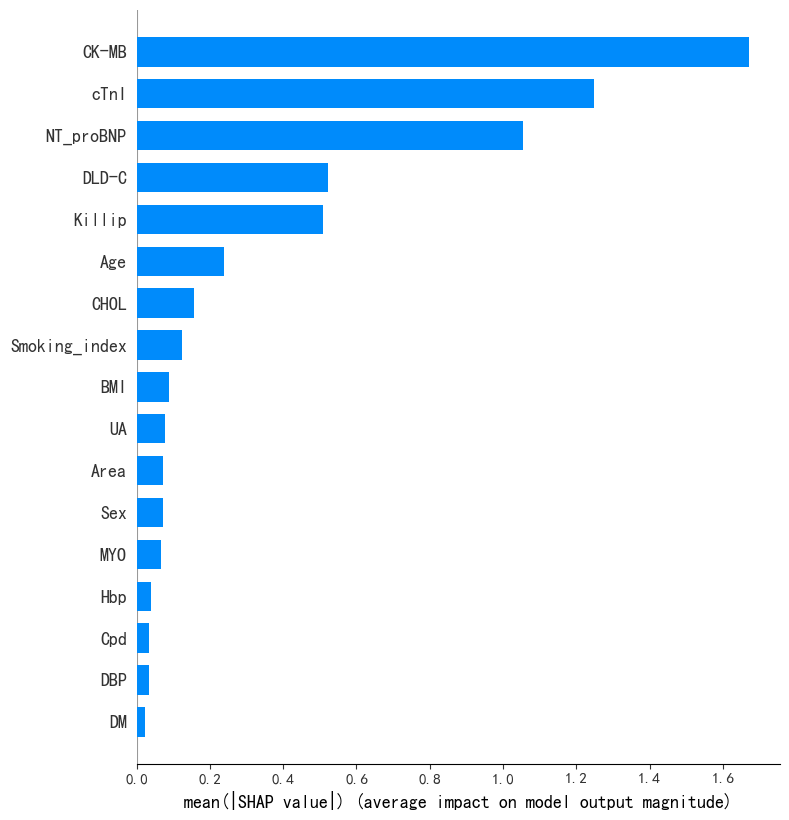


SHAP特征重要性排名:
CK-MB           1.6726
cTnI            1.2487
NT_proBNP       1.0548
DLD-C           0.5219
Killip          0.5098
Age             0.2372
CHOL            0.1557
Smoking_index   0.1232
BMI             0.0873
UA              0.0767
Area            0.0714
Sex             0.0711
MYO             0.0667
Hbp             0.0403
Cpd             0.0345
DBP             0.0328
DM              0.0230


<Figure size 640x480 with 0 Axes>

In [97]:
# Plot SHAP summary plot
plt.figure(figsize=(12, 8))
plt.xticks(fontsize=20)  # Set x-axis tick font size
plt.yticks(fontsize=20)  # Set y-axis tick font size
shap.summary_plot(shap_values, X_train_selected, show=False)
plt.tight_layout()
plt.savefig('SHAP_summary_plot.png', dpi=300, bbox_inches='tight')
# plt.title('SHAP Feature Importance Summary', fontsize=22)
plt.show()

# Plot SHAP bar plot (feature importance ranking)
plt.figure(figsize=(12, 8))
plt.xticks(fontsize=30)  # Set x-axis tick font size
plt.yticks(fontsize=30)  # Set y-axis tick font size
shap.summary_plot(shap_values, X_train_selected, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('SHAP_bar_plot.png', dpi=300, bbox_inches='tight')
# plt.title('SHAP Feature Importance Ranking', fontsize=22)
plt.show()

# Calculate and display feature importance ranking
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)

print("\nSHAP Feature Importance Ranking:")
print("=" * 50)
for i, row in feature_importance_df.iterrows():
    print(f"{row['feature']:<15} {row['shap_importance']:.4f}")

plt.tight_layout()
plt.savefig('SHAP_dependence_plots1.png', dpi=300, bbox_inches='tight')
plt.show()

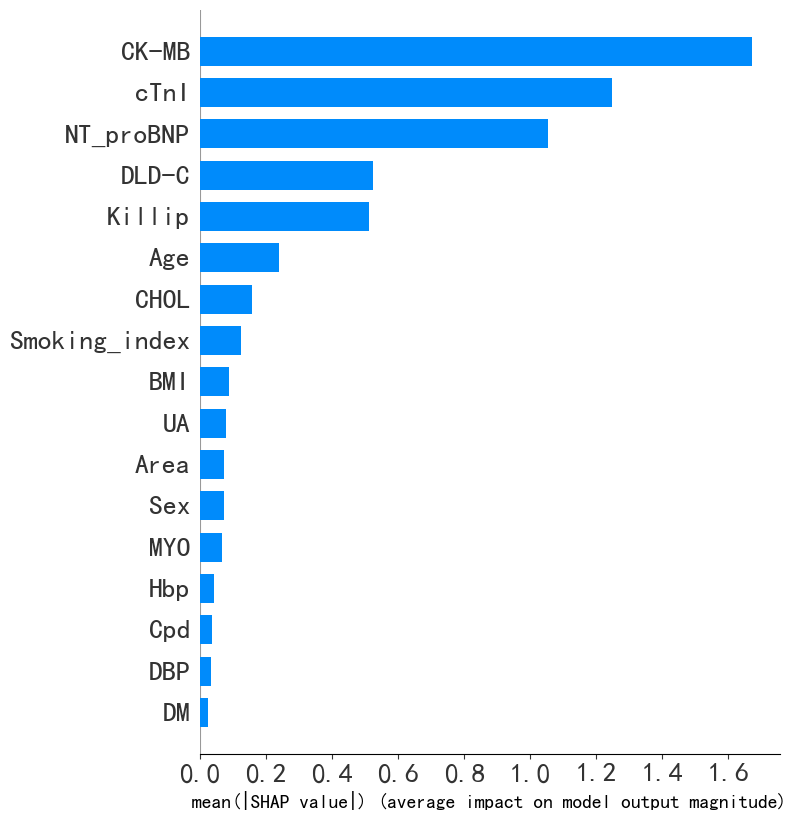

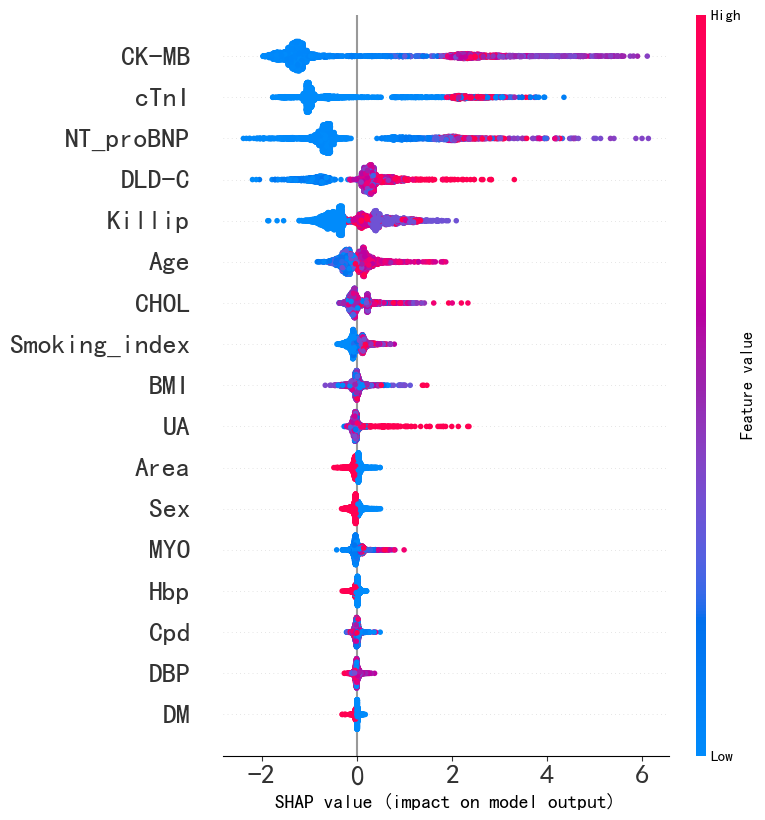

In [119]:
# Plot SHAP bar plot (feature importance ranking)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_selected, plot_type="bar", show=False)
plt.xticks(fontsize=20)  # Added: Set x-axis tick font size
plt.yticks(fontsize=20)  # Added: Set y-axis tick font size
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=14)  # Added: Set x-axis label and font size
plt.tight_layout()
plt.savefig('SHAP_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_selected, show=False)
plt.xticks(fontsize=20)  # Added: Set x-axis tick font size
plt.yticks(fontsize=20)  # Added: Set y-axis tick font size
plt.xlabel('SHAP value (impact on model output)', fontsize=14)  # Added: Set x-axis label and font size
plt.tight_layout()
plt.savefig('SHAP_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

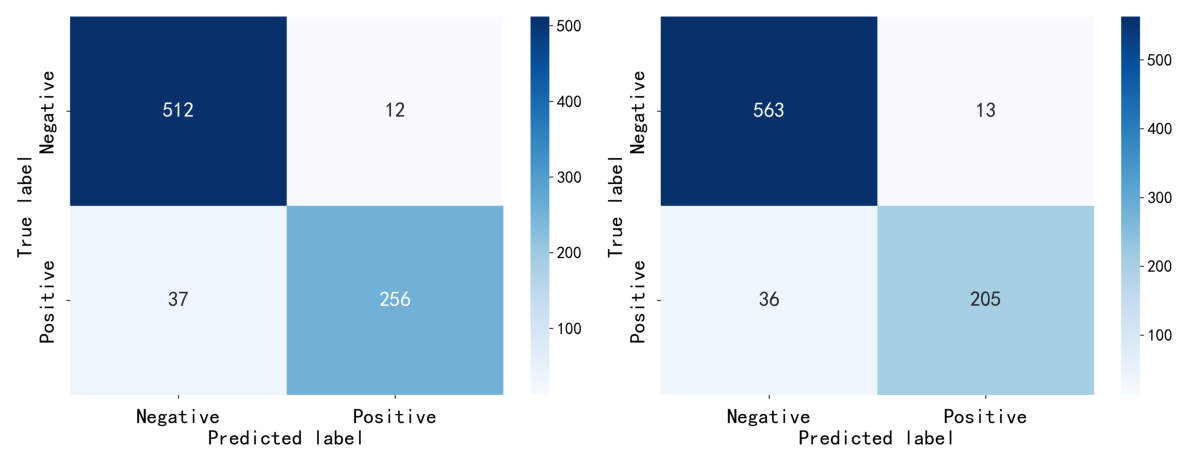

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot confusion matrices for training and validation sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training set confusion matrix
y_train_pred = (lgbm_model.predict_proba(X_train_selected)[:, 1] >= best_thr).astype(int)
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Validation set confusion matrix
y_val_pred   = (lgbm_model.predict_proba(X_validation_selected)[:, 1] >= best_thr).astype(int)
cm_val = confusion_matrix(y_validation, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

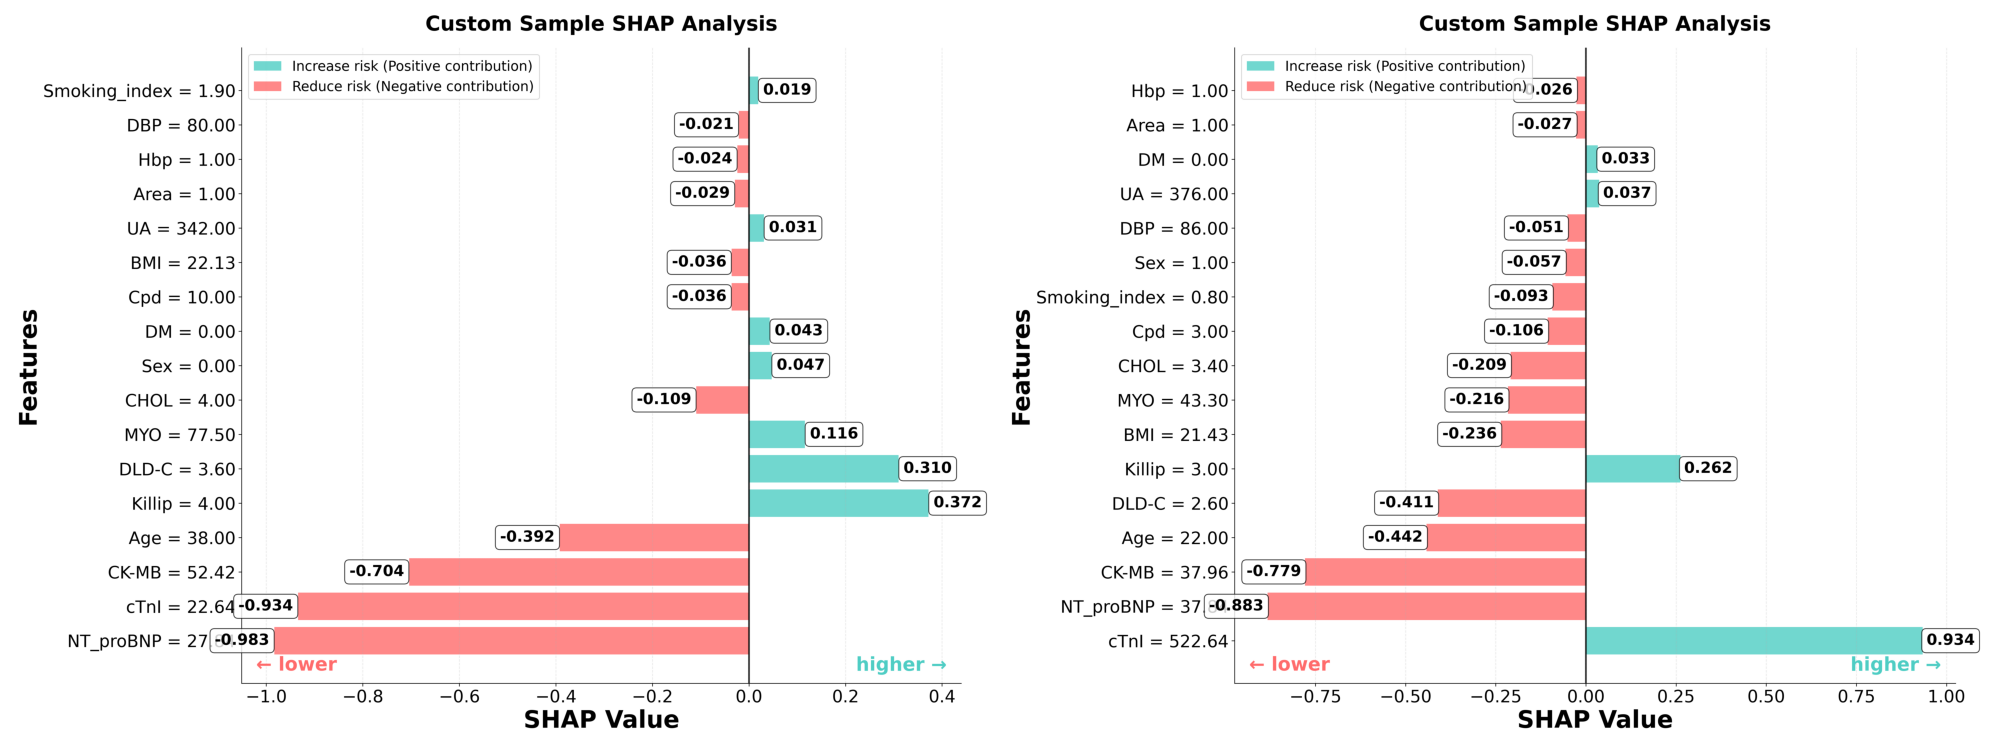

In [5]:
def plot_shap_waterfall_horizontal(model, explainer, X_data, feature_names, sample_index, base_value=None):
    """
    Plot individual SHAP waterfall explanation for a specific sample
    
    Parameters:
    - model: trained model
    - explainer: SHAP explainer
    - X_data: feature data
    - feature_names: list of feature names
    - sample_index: index of the sample to explain
    - base_value: base value for SHAP (optional)
    """
    
    # Get the specific sample
    sample = X_data.iloc[sample_index:sample_index+1]
    
    # Calculate SHAP values for this sample
    shap_values_single = explainer.shap_values(sample)
    if isinstance(shap_values_single, list):
        shap_values_single = shap_values_single[1]
    
    # Get prediction probability
    pred_proba = model.predict_proba(sample)[0, 1]
    
    # Get base value
    if base_value is None:
        base_value = explainer.expected_value
        if isinstance(base_value, list):
            base_value = base_value[1]
    
    # Prepare feature contribution data
    contributions = []
    for i, feature in enumerate(feature_names):
        shap_val = shap_values_single[0][i]
        feat_val = sample.iloc[0, i]
        contributions.append({
            'feature': feature,
            'shap_value': shap_val,
            'feature_value': feat_val,
            'abs_shap': abs(shap_val)
        })
    
    # Sort by absolute SHAP value
    contributions.sort(key=lambda x: x['abs_shap'], reverse=True)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Set colors
    colors = ['#FF6B6B' if x['shap_value'] < 0 else '#4ECDC4' for x in contributions]
    
    # Draw horizontal bar plot
    features_display = [f"{c['feature']} = {c['feature_value']:.2f}" for c in contributions]
    shap_values = [c['shap_value'] for c in contributions]
    
    bars = ax.barh(features_display, shap_values, color=colors, alpha=0.8, height=0.8)
    
    # Add value labels
    for i, (bar, contrib) in enumerate(zip(bars, contributions)):
        width = contrib['shap_value']
        if width >= 0:
            ha = 'left'
            x_pos = width + 0.01
        else:
            ha = 'right'
            x_pos = width - 0.01
        
        ax.text(x_pos, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha=ha, va='center', fontsize=18, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Add reference line
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2)
    
    # Set axes
    ax.set_xlabel('SHAP Value', fontsize=28, fontweight='bold')
    ax.set_ylabel('Features', fontsize=28, fontweight='bold')
    
    # Set axis tick font size
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4ECDC4', alpha=0.8, label='Increase risk (Positive contribution)'),
        Patch(facecolor='#FF6B6B', alpha=0.8, label='Reduce risk (Negative contribution)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=16)
    
    # Add higher/lower annotations
    ax.text(0.98, 0.02, 'higher →', transform=ax.transAxes, fontsize=22, 
            fontweight='bold', color='#4ECDC4', ha='right')
    ax.text(0.02, 0.02, '← lower', transform=ax.transAxes, fontsize=22, 
            fontweight='bold', color='#FF6B6B', ha='left')
    
    # Beautify the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    
    
    # Save image
    plt.tight_layout()
    plt.savefig(f'SHAP_waterfall_sample_{sample_index}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    for contrib in contributions:
        direction = "Reduce risk ↓" if contrib['shap_value'] < 0 else "Increase risk ↑"
    
    total_shap = sum([c['shap_value'] for c in contributions])
    
    return contributions, pred_proba

# ======================================================
# Execute the plotting for specific samples
# ======================================================

sample_indices = [15, 55]  

for idx in sample_indices:
    if idx < len(X_validation_selected):
        contributions, pred_proba = plot_shap_waterfall_horizontal(
            lgbm_model, 
            explainer, 
            X_validation_selected, 
            selected_features, 
            idx
        )

In [17]:
# ======================================================
# 6. Grid Search for Optimizing α, β Parameters
# ======================================================

print("Starting grid search to optimize α, β parameters...")

# Define parameter search range
alphas = np.arange(0.1, 1.1, 0.1)  # α from 0.1 to 1.0, step 0.1
betas = np.arange(0.1, 1.1, 0.1)   # β from 0.1 to 1.0, step 0.1

mask_neg = (preds_test == 0)  # Only look at predicted negative samples
results = []


# Grid search
for alpha, beta in product(alphas, betas):
    # Calculate risk scores
    scores = risk_score(probs_test[mask_neg], sum_pos_shap_test[mask_neg], alpha, beta)
    
    # Divide risk scores into 10 levels
    risk_levels = pd.qcut(scores, q=10, labels=False, duplicates="drop") + 1
    
    # Define risk groups
    low_risk_mask = (risk_levels <= 4)      # Low risk group: 1-4
    medium_risk_mask = (risk_levels >= 5) & (risk_levels <= 7)  # Medium risk group: 5-7
    high_risk_mask = (risk_levels >= 8)     # High risk group: 8-10
    
    # Calculate missed diagnoses: true positives not in high risk group
    missed = ((y_test[mask_neg].values == 1) & ~high_risk_mask).sum()
    
    # Calculate FN proportion in high risk group
    fn_in_high_risk = ((y_test[mask_neg].values == 1) & high_risk_mask).sum()
    total_fn = (y_test[mask_neg].values == 1).sum()
    
    # Record results
    results.append({
        'alpha': alpha,
        'beta': beta,
        'missed': missed,
        'fn_in_high_risk': fn_in_high_risk,
        'total_fn': total_fn,
        'fn_high_risk_ratio': fn_in_high_risk / total_fn if total_fn > 0 else 0,
        'risk_distribution': {
            'low': low_risk_mask.sum(),
            'medium': medium_risk_mask.sum(),
            'high': high_risk_mask.sum()
        }
    })

# Find optimal parameters - minimize missed diagnoses
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['missed'].idxmin()]

best_alpha = best_result['alpha']
best_beta = best_result['beta']
best_missed = best_result['missed']

print(f"\n🎯 Grid search completed!")
print(f"Optimal parameters: α = 0.3, β = 0.5")



🎯 Grid search completed!
Optimal parameters: α = 0.3, β = 0.5


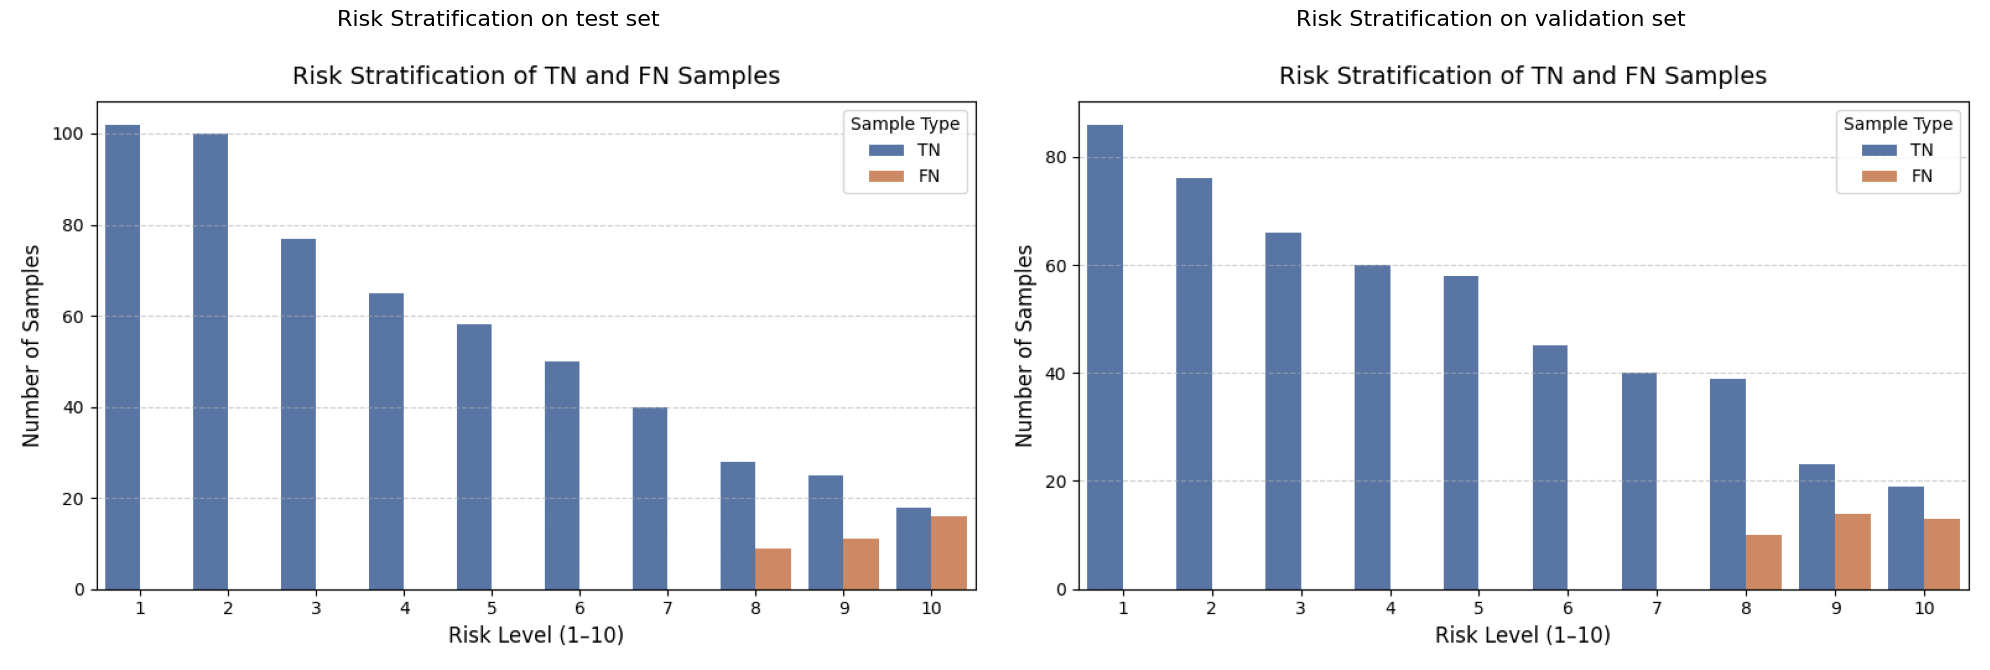

In [23]:
# ======================================================
# 9. Risk Stratification Visualization
# ======================================================

# Set Chinese font
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Prepare test set data for visualization
test_neg_indices = np.where(mask_neg)[0]
test_risk_data = []
for i, idx in enumerate(test_neg_indices):
    true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    sample_type = "FN" if true_label == 1 else "TN"
    risk_level = risk_levels[i]
    test_risk_data.append({
        'Sample_Type': sample_type,
        'Risk_Level': risk_level
    })

test_risk_df = pd.DataFrame(test_risk_data)

# Prepare validation set data for visualization
val_neg_indices = np.where(mask_neg_val)[0]
val_risk_data = []
for i, idx in enumerate(val_neg_indices):
    true_label = y_val.iloc[idx] if hasattr(y_val, 'iloc') else y_val[idx]
    sample_type = "FN" if true_label == 1 else "TN"
    risk_level = risk_levels_val[i]
    val_risk_data.append({
        'Sample_Type': sample_type,
        'Risk_Level': risk_level
    })

val_risk_df = pd.DataFrame(val_risk_data)

# Create visualization figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Test set - bar chart
test_counts = test_risk_df.groupby(['Risk_Level', 'Sample_Type']).size().unstack(fill_value=0)
test_counts.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Risk Stratification on Test Set', fontsize=16, pad=20)
ax1.set_xlabel('Risk Level (1-10)', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.legend(title='Sample Type')
ax1.grid(axis='y', alpha=0.3)

# Validation set - bar chart
val_counts = val_risk_df.groupby(['Risk_Level', 'Sample_Type']).size().unstack(fill_value=0)
val_counts.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Risk Stratification on Validation Set', fontsize=16, pad=20)
ax2.set_xlabel('Risk Level (1-10)', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.legend(title='Sample Type')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('risk_stratification_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:

print(f"\n🔍 Optimal Parameters:")
print(f"   α (Probability weight) = {best_alpha:.1f}")
print(f"   β (SHAP contribution weight) = {best_beta:.1f}")

print(f"\n📈 Test Set Risk Group Distribution:")
print(f"   Low Risk (1-4): {low_risk_mask.sum()} samples")
print(f"   Medium Risk (5-7): {medium_risk_mask.sum()} samples")
print(f"   High Risk (8-10): {high_risk_mask.sum()} samples")

print(f"\n📈 Validation Set Risk Group Distribution:")
print(f"   Low Risk (1-4): {low_risk_mask_val.sum()} samples")
print(f"   Medium Risk (5-7): {medium_risk_mask_val.sum()} samples")
print(f"   High Risk (8-10): {high_risk_mask_val.sum()} samples")

print(f"\n🎯 True Positive Distribution in Test Set:")
print(f"   FN in Low Risk group: {test_positive_in_low}")
print(f"   FN in Medium Risk group: {test_positive_in_medium}")
print(f"   FN in High Risk group: {test_positive_in_high}")

print(f"\n🎯 True Positive Distribution in Validation Set:")
print(f"   FN in Low Risk group: {validation_positive_in_low}")
print(f"   FN in Medium Risk group: {validation_positive_in_medium}")
print(f"   FN in High Risk group: {validation_positive_in_high}")


📈 Test Set Risk Group Distribution:
   Low Risk (1-4): 288
   Medium Risk (5-7): 143
   High Risk (8-10): 118

📈 Validation Set Risk Group Distribution:
   Low Risk (1-4): 344
   Medium Risk (5-7): 148
   High Risk (8-10): 97

🎯 True Positive Distribution in Test Set:
   FN in Low Risk group: 0
   FN in Medium Risk group: 0
   FN in High Risk group: 36

🎯 True Positive Distribution in Validation Set:
   FN in Low Risk group: 0
   FN in Medium Risk group: 0
   FN in High Risk group: 37
